In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg
from datetime import datetime
from enum import Enum
import time
%matplotlib inline

In [2]:
class SensorName(Enum):

    ACC = 'accelerometeruncalibrated'
    GYRO = 'gyroscopeuncalibrated'

In [3]:
connection = pg.connect(user="admin",
                            password="quest",
                            host="127.0.0.1",
                            port="8812",
                            database="qdb",
                            options='-c statement_timeout=300000')

In [50]:
'''cursor = connection.cursor()

#Creating Table Station_Status
cursor.execute("DROP TABLE IF EXISTS acc")
sql = """CREATE TABLE acc (
        device_id TEXT,
        session_id TEXT,
        recorded_timestamp TEXT,
        x REAL,
        y REAL,
        z REAL)"""

cursor.execute(sql)
connection.commit()'''


In [4]:
query = """with tmp as (select device_id,
                        recorded_timestamp,
                        x,
                        y,
                        z,
                        row_number() over(partition by device_id order by
                                        recorded_timestamp desc) as rn
                        from acc )

                select * from tmp where rn <= 40"""

data = pd.read_sql(query, connection)
data['device_id'].unique()

/var/folders/9r/y3yrm7yx2x31dxvgqt8pww3h0000gn/T/ipykernel_4928/709094810.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


array(['30d0b4d5-5f4f-4bd3-862f-49e39a81d338',
       '86a5b0e3-6e06-40e2-b226-5a72bd39b65b'], dtype=object)

In [6]:
data = pd.read_sql("select * from acc", connection)
data.sort_values('recorded_timestamp')

/var/folders/9r/y3yrm7yx2x31dxvgqt8pww3h0000gn/T/ipykernel_4866/2865897781.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql("select * from acc", connection)


,device_id,session_id,recorded_timestamp,x,y,z
0,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.954855,-0.081,-0.722,-0.697
1,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.974909,-0.094,-0.718,-0.677
2,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:09.994963,-0.103,-0.706,-0.664
3,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:10.015016,-0.096,-0.710,-0.670
4,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,2680b42b-2dce-47f7-bc20-9e01573ea062,2022-10-15 14:05:10.035070,-0.079,-0.718,-0.688
...,...,...,...,...,...,...
19901,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,f6c0bb84-161e-4768-827f-6f7f75492f1f,2022-11-20 13:17:46.605716,0.002,-0.005,-0.998
19902,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,f6c0bb84-161e-4768-827f-6f7f75492f1f,2022-11-20 13:17:46.625772,0.005,-0.004,-0.996
19903,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,f6c0bb84-161e-4768-827f-6f7f75492f1f,2022-11-20 13:17:46.645827,0.007,-0.001,-0.998
19904,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,f6c0bb84-161e-4768-827f-6f7f75492f1f,2022-11-20 13:17:46.665882,0.006,0.002,-0.997


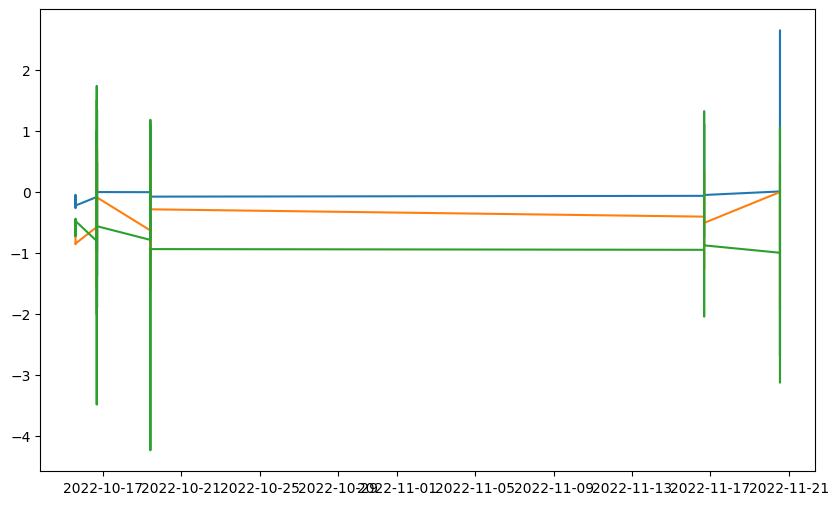

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for axis in ['x','y','z']:

    ax.plot(pd.to_datetime(data['recorded_timestamp']), data[axis])

In [43]:
connection.cursor().execute('''drop table acc''')

In [44]:
connection.close()